### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

### Download data

In [1]:
#!g1.1
from gfile import download_list

download_list(
    url='https://drive.google.com/file/d/1F96x4LDbsTZGMMq81fZr7aduJCe8N95O',
    filename='celeba.zip',
    target_dir='.'
)

It took  41.26sec to download 2.5 GB celeba.zip 


In [ ]:
#!g1.1:bash
unzip celeba.zip

In [3]:
#!g1.1
%pip install --upgrade torch

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 804.1 MB 1.1 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.7.0 requires torch==1.6.0, but you have torch 1.8.1 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.2.0 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires torch==1.6.0, but you have torch 1.8.1 which is incompatible.
enot-utils 1.0.2 requires torch==1.6.0, but you have torch 1.8.1 which is incompatible.


In [1]:
#!g1.1
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4
BATCH_SIZE = 32

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Prepare dataset

In [2]:
#!g1.1
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
#!g1.1

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.Grayscale(),
        torchvision.transforms.ToTensor()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.Grayscale(),
        torchvision.transforms.ToTensor()
    ]),
)

---

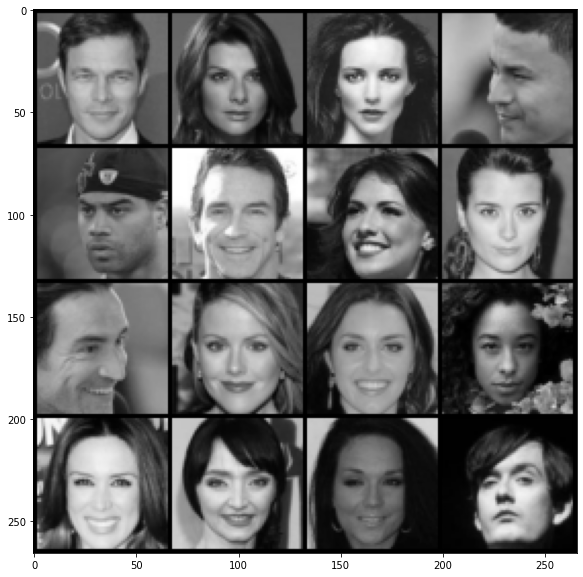

In [7]:
#!g1.1
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

**Hint**: you may need nn.Flatten and nn.Unflatten

In [4]:
#!g1.1
class PCAAutoEncoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32, image_size = (1, 64, 64)):
        super(PCAAutoEncoder, self).__init__()
        
        self.image_size = image_size
        
        self.enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64, code_size)
        )
        
        self.dec = nn.Sequential(
            nn.Linear(code_size, 64 * 64),
            nn.Unflatten(1, (1, 64, 64))
        )
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction) ** 2)

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

In [5]:
#!g1.1
def train(model, dataset, num_epoch=32):
    model.to(device)
    optimizer = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    for epoch in range(num_epoch):
        losses = []
        
        for i, (batch, _) in enumerate(dataloader):
            optimizer.zero_grad()
            loss = model.batch_loss(batch.to(device))
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()
        
        print(f"#{epoch + 1}, Train loss: {np.mean(losses)}")

In [6]:
#!g1.1
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    code = model.enc(img[None].to(device))
    reco = model.dec(code)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1).squeeze())

    plt.subplot(1, 3, 2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1).squeeze())
    
    if img.squeeze().dim() == 2:
        plt.gray()
    
    plt.show()


In [11]:
#!g1.1
aenc = PCAAutoEncoder()
train(aenc, train_dataset, 10)

#1, Train loss: 0.0365181528031826
#2, Train loss: 0.0112607441842556
#3, Train loss: 0.010113326832652092
#4, Train loss: 0.010056672617793083
#5, Train loss: 0.010033941827714443
#6, Train loss: 0.010024970397353172
#7, Train loss: 0.010023201815783978
#8, Train loss: 0.010018166154623032
#9, Train loss: 0.01001092977821827
#10, Train loss: 0.010016950778663158


In [12]:
#!g1.1
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
scores = []

for i, (batch, _) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch.to(device)).data.cpu().numpy())

print(np.mean(scores))

0.00993403


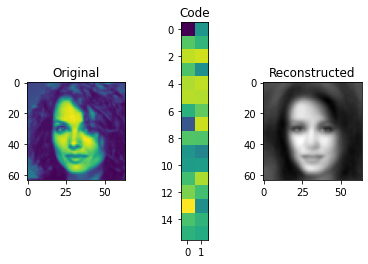

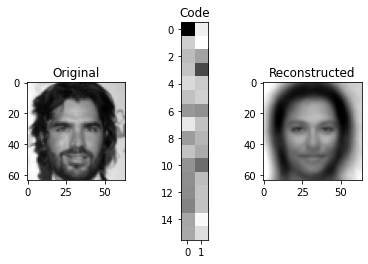

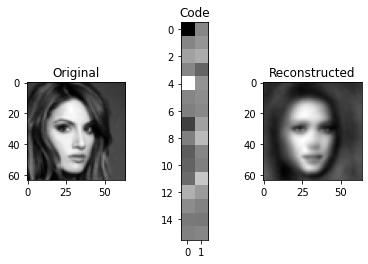

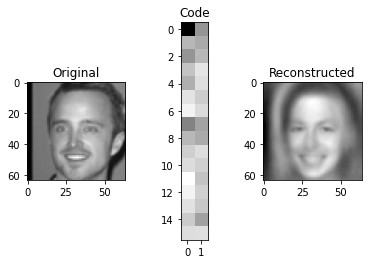

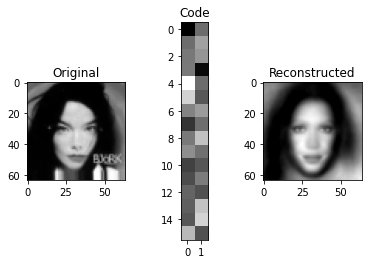

In [13]:
#!g1.1
for i in range(5):
    img = validation_dataset[i][0]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are good idea. To undo convolution use nn.Upsample + nn.Conv2d
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [7]:
#!g1.1
class DeepPCAAutoEncoder(nn.Module):
    def __init__(self, code_size=32, image_size = (1, 64, 64)):
        super(DeepPCAAutoEncoder, self).__init__()
        
        self.image_size = image_size
        
        self.enc = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128,  kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),

            nn.Linear(128 * 16 * 16, 1024),
            nn.ReLU(),
  
            nn.Linear(1024, code_size)
        )
        
        self.dec = nn.Sequential(
            nn.Linear(code_size, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, 128 * 16 * 16),
            nn.ReLU(),
            
            nn.Unflatten(1, (128, 16, 16)),    
                    
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)

In [15]:
#!g1.1
aenc_deep = DeepPCAAutoEncoder()
train(aenc_deep, train_dataset, 60)

#1, Train loss: 0.010499800555408001
#2, Train loss: 0.007895409129559994
#3, Train loss: 0.007588904816657305
#4, Train loss: 0.007409390062093735
#5, Train loss: 0.0072836182080209255
#6, Train loss: 0.007187195587903261
#7, Train loss: 0.0071084871888160706
#8, Train loss: 0.0070404913276433945
#9, Train loss: 0.006981846876442432
#10, Train loss: 0.006930575240403414
#11, Train loss: 0.0068831853568553925
#12, Train loss: 0.006836937740445137
#13, Train loss: 0.006799865514039993
#14, Train loss: 0.006758944597095251
#15, Train loss: 0.006725354120135307
#16, Train loss: 0.006690165959298611
#17, Train loss: 0.006657032761722803
#18, Train loss: 0.006624980363994837
#19, Train loss: 0.006594800855964422
#20, Train loss: 0.006562219467014074
#21, Train loss: 0.006534588988870382
#22, Train loss: 0.006506713572889566
#23, Train loss: 0.0064762672409415245
#24, Train loss: 0.006450785789638758
#25, Train loss: 0.006422890815883875
#26, Train loss: 0.006395680829882622
#27, Train loss:

In [17]:
#!g1.1
torch.save(aenc.state_dict(), './aenc__model')
torch.save(aenc_deep.state_dict(), './aenc_deep__model')

Training may take long, it's okay.

**Check autoencoder shapes along different code_sizes. Check architecture of you encoder-decoder network is correct**

In [36]:
#!g1.1
def get_dim(layer): return np.prod(layer.output_shape[1:])


for code_size in [1, 8, 32, 128, 512, 1024]:
    help_tensor = next(iter(DataLoader(train_dataset, batch_size=BATCH_SIZE)))
    model = DeepPCAAutoEncoder(code_size).to(device)
    encoder_out = model.enc(help_tensor[0].to(device))
    decoder_out = model.dec(encoder_out)

    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size(
        [code_size]), "encoder must output a code of required size"
    assert decoder_out.shape[1:] == model.image_size, "decoder must output an image of valid shape"
    assert len(list(model.dec.children())) >= 6,  "decoder must contain at least 3 dense layers"

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

Final MSE: 0.007445346


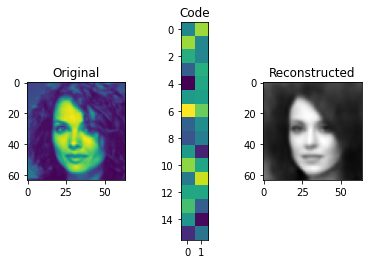

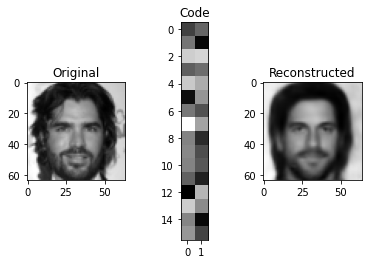

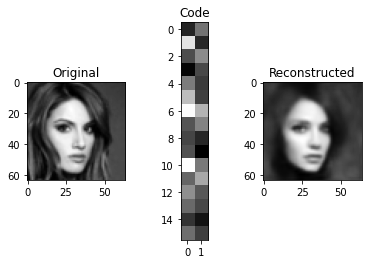

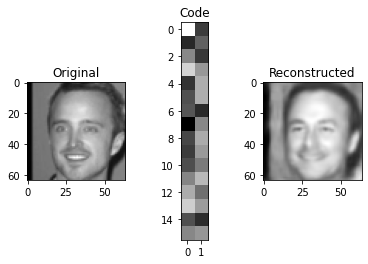

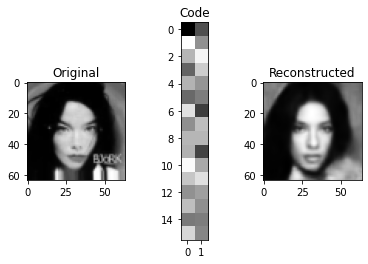

In [43]:
#!g1.1
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch[0].to(device)).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch[0].to(device))

reconstruction_mse = np.mean(scores)

assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 32, \
    "Make sure encoder has code_size units"

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = validation_dataset[i][0]
    visualize(img, aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [44]:
#!g1.1
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
        
    noise = np.random.normal(loc = 0, scale = sigma, size = X.shape)
        
    return X + noise
    

**noise tests**

In [45]:
#!g1.1
X = torch.stack([train_dataset[i][0] for i in range(100)], dim=0)
theoretical_std = (X.std() ** 2 + 0.5 ** 2) ** .5
our_std = apply_gaussian_noise(X, sigma=0.5).std()

assert abs(theoretical_std - our_std) < 0.01, \
    "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X, sigma=0.5).mean() - X.mean()) < 0.01, \
    "Mean has changed. Please add zero-mean noise"

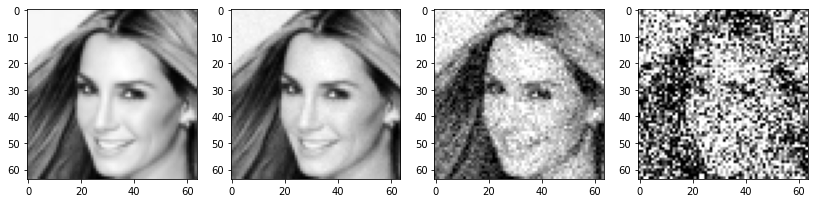

In [51]:
#!g1.1
plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1)
plt.imshow(X[0].permute([1, 2, 0]))
plt.subplot(1, 4, 2)
plt.imshow(apply_gaussian_noise(X[:1], sigma=0.01)[0].permute([1, 2, 0]).clip(0, 1))
plt.subplot(1, 4, 3)
plt.imshow(apply_gaussian_noise(X[:1], sigma=0.1)[0].permute([1, 2, 0]).clip(0, 1))
plt.subplot(1, 4, 4)
plt.imshow(apply_gaussian_noise(X[:1], sigma=0.5)[0].permute([1, 2, 0]).clip(0, 1))

In [77]:
#!g1.1
class PCAAutoEncoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32, image_size = (1, 64, 64)):
        super(PCAAutoEncoder, self).__init__()
        
        self.image_size = image_size
        
        self.enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64, code_size)
        )
        
        self.dec = nn.Sequential(
            nn.Linear(code_size, 64 * 64),
            nn.Unflatten(1, (1, 64, 64))
        )
        
    def forward(self, batch):
        return self.dec(self.enc(batch))
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction) ** 2)

In [102]:
#!g1.1
def train_noise(model, dataset, num_epoch=50):
    model.to(device)
    optimizer = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    for epoch in range(num_epoch):
        losses = []
        
        for i, (batch, _) in enumerate(dataloader):
            optimizer.zero_grad()
            batch_noise = apply_gaussian_noise(batch).float()
            reconstruction = model(batch_noise.to(device))
            loss = torch.mean((batch.to(device) - reconstruction) ** 2)
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()
        
        print(f"#{epoch + 1}, Train loss: {np.mean(losses)}")

__Note:__ You may change the way the training with noise is done, if you want. For example, you may change Dataloader or batch_loss function in model and leave train function unchanged.

In [103]:
#!g1.1
aenc_noise = PCAAutoEncoder()
train_noise(aenc_noise, train_dataset, 10)

#1, Train loss: 0.039507362991571426
#2, Train loss: 0.011857043020427227
#3, Train loss: 0.010348530486226082
#4, Train loss: 0.010235008783638477
#5, Train loss: 0.010205828584730625
#6, Train loss: 0.010180122219026089
#7, Train loss: 0.0101748276501894
#8, Train loss: 0.010164319537580013
#9, Train loss: 0.010171548463404179
#10, Train loss: 0.010164677165448666


In [146]:
#!g1.1
#!g1.1
torch.save(aenc_noise.state_dict(), './aenc_noise_model')

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

**Let's evaluate!!!**

Final MSE: 0.010356633


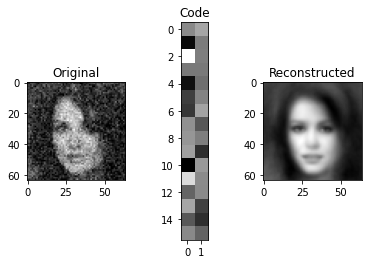

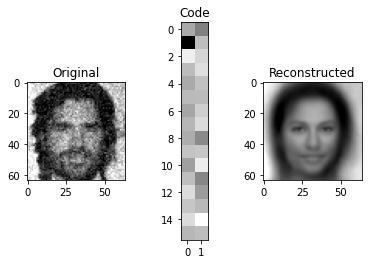

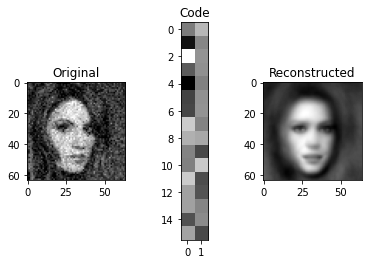

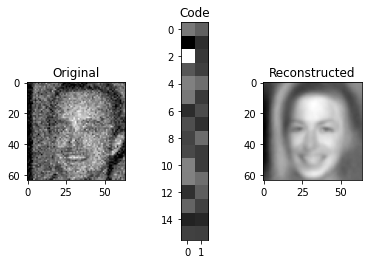

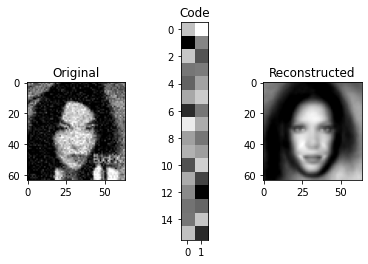

In [108]:
#!g1.1
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
scores = []

for i, (batch, _) in enumerate(dataloader_test):
    batch_noise = apply_gaussian_noise(batch[0]).float()
    reconstruction = aenc_noise(batch_noise.to(device))
    scores.append(torch.mean((batch[0].to(device) - reconstruction) ** 2).data.cpu().numpy())

reconstruction_mse = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(validation_dataset[i][0]).float()
    visualize(img, aenc_noise)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space.

To speed up retrieval process, we shall use [hnswlib](https://github.com/nmslib/hnswlib) on top of encoded vectors. hnswlib is fast approximate nearest neighbor search. If you want to learn more about fast kNN, take a look at https://github.com/erikbern/ann-benchmarks.

In [11]:
#!g1.1
aenc = PCAAutoEncoder()
aenc.load_state_dict(torch.load('./aenc__model'))
aenc.to(device)

PCAAutoEncoder(
  (enc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=32, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=32, out_features=4096, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(1, 64, 64))
  )
)

In [55]:
#!g1.1
# encodes batch of images into a codes
codes = [aenc.enc(torch.unsqueeze(X, 0).to(device))[0] for X, _ in train_dataset]

In [56]:
#!g1.1
codes = torch.stack(codes)

In [57]:
#!g1.1
assert codes.shape[0] == len(train_dataset)

In [59]:
#!g1.1
import hnswlib

search_index = hnswlib.Index(space='l2', dim=codes.shape[1])
search_index.init_index(max_elements=codes.shape[0], ef_construction=200, M=16)
search_index.add_items(codes.detach().cpu().numpy(), np.arange(codes.shape[0]))
search_index.set_ef(50)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: search_index
  warnings.warn(message)


In [91]:
#!g1.1
X_train = np.array([X[0].numpy() for X, _ in train_dataset])

In [116]:
#!g1.1
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch,height,width,3]"

    code =  aenc.enc(torch.unsqueeze(image, 0).to(device)).detach().cpu().numpy()[0]
    
    (labels, ), (distances,) = search_index.knn_query(code, k=n_neighbors)
    return distances, X_train[labels]

In [121]:
#!g1.1
def show_similar(image):

    distances, neighbors = get_similar(image, n_neighbors=11)

    plt.figure(figsize=[10, 8])
    plt.subplot(3, 4, 1)
    plt.imshow(image.cpu().numpy().transpose([1, 2, 0]), cmap=plt.get_cmap('gray'))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i], cmap=plt.get_cmap('gray'))
        plt.title("Dist=%.3f" % distances[i])
    plt.show()

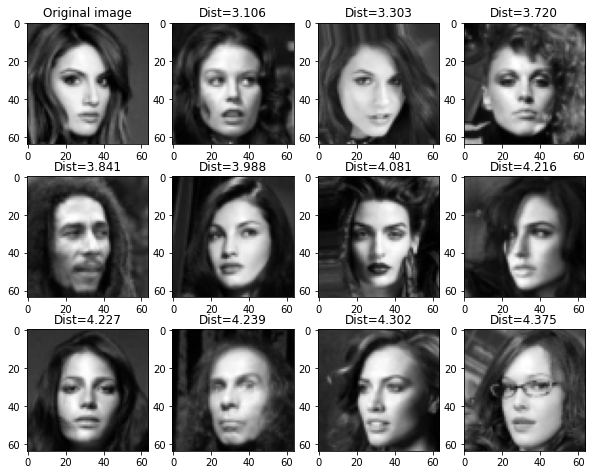

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: search_index
  warnings.warn(message)


In [122]:
#!g1.1
show_similar(validation_dataset[2][0])

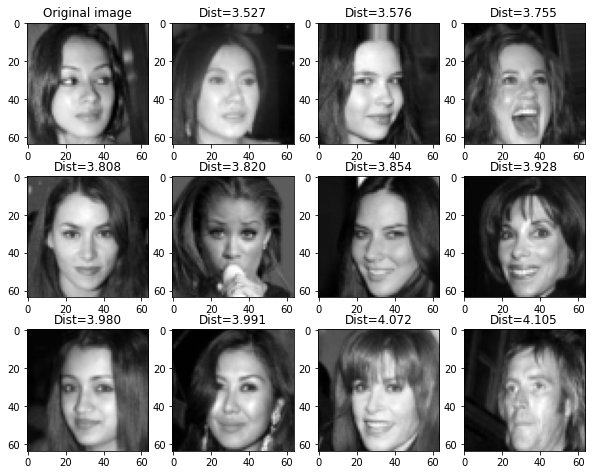

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: search_index
  warnings.warn(message)


In [123]:
#!g1.1
show_similar(validation_dataset[500][0])

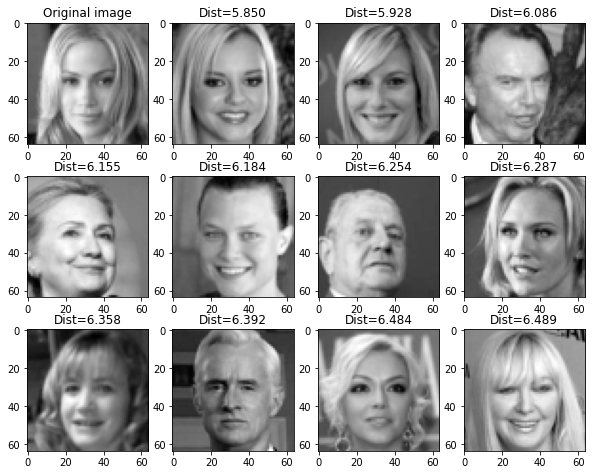

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: search_index
  warnings.warn(message)


In [124]:
#!g1.1
show_similar(validation_dataset[66][0])

## Cheap image morphing


Here you should take two full-sized objects, code it and obtain intermediate object by decoding an intermixture code.

$Code_{mixt} = a1\cdot code1 + a2\cdot code2$

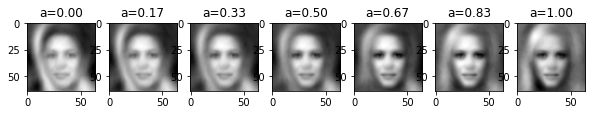

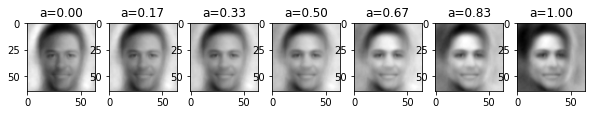

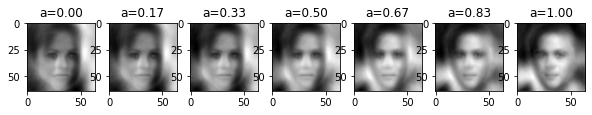

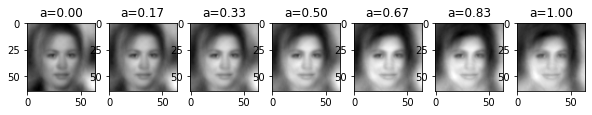

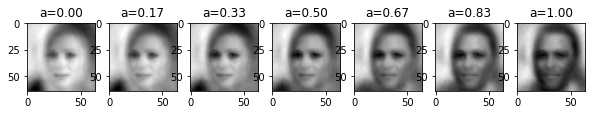

In [41]:
#!g1.1
for _ in range(5):
    image1 = torch.unsqueeze(train_dataset[np.random.randint(0, len(train_dataset))][0], 0)
    image2 = torch.unsqueeze(train_dataset[np.random.randint(0, len(train_dataset))][0], 0)

    code1, code2 =  aenc.enc(image1.to(device)), aenc.enc(image2.to(device))
    
    plt.figure(figsize=[10, 4])
    for i, a in enumerate(np.linspace(0, 1, num=7)):

        output_code =  a * code1[0] + (1 - a) * code2[0]

        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1, 7, i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1, 2, 0]), cmap=plt.get_cmap('gray'))
        plt.title("a=%.2f" % a)

    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.